In [1]:
import parent

In [2]:
import networks


In [3]:
import data

In [21]:
d1, d2 = data.get_dataset_triangles(
    "train", data_size=28, hollow=True
)

In [22]:
image_A, image_B = (x[0].cuda() for x in next(zip(d1, d2)))

In [23]:
import torch
from torch import nn
import numpy as np
from mermaidlite import compute_warped_image_multiNC, identity_map_multiN

import torch.nn.functional as F

class DenseMatrixNet(nn.Module):
    def __init__(self, size=28, dimension=2):
        super(DenseMatrixNet, self).__init__()
        self.dimension=dimension
        self.size=size
        self.dense1 = nn.Linear(size *size  * 2, 800)
        self.dense2 = nn.Linear(800, 300)
        self.dense3 = nn.Linear(300, 6 if self.dimension == 2 else 12)
        torch.nn.init.zeros_(self.dense3.weight)

    def forward(self, x, y):
        x = torch.reshape(torch.cat([x, y], 1), (-1, 2 * self.size * self.size))
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        if self.dimension == 3:
            x = torch.reshape(x, (-1, 3, 4))
            x = torch.cat([x, torch.Tensor([[[0, 0, 0, 1]]]).cuda().expand(x.shape[0], -1, -1)], 1)
            x = x + torch.Tensor([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]]).cuda()
        elif self.dimension==2:
            x = torch.reshape(x, (-1, 2, 3))
            x = torch.cat([x, torch.Tensor([[[0, 0, 1]]]).cuda().expand(x.shape[0], -1, -1)], 1)
            x = x + torch.Tensor([[1, 0, 0], [0, 1, 0], [0, 0, 0]]).cuda()
        else:
            raise ArgumentError()
        return x


class InverseConsistentAffineNet(nn.Module):
    def __init__(self, network, lmbda, input_shape):
        super(InverseConsistentAffineNet, self).__init__()

        self.sz = np.array(input_shape)
        self.spacing = 1.0 / (self.sz[2::] - 1)

        _id = identity_map_multiN(self.sz, self.spacing)
        self.register_buffer("identityMap", torch.from_numpy(_id))
        
        _id_projective = np.concatenate([_id, np.ones(input_shape)], axis=1)
        self.register_buffer("identityMapProjective", torch.from_numpy(_id_projective).float())
        self.map_shape = self.identityMap.shape
        self.regis_net = network
        self.lmbda = lmbda

    def adjust_batch_size(self, BATCH_SIZE):
        self.sz[0] = BATCH_SIZE
        self.spacing = 1.0 / (self.sz[2::] - 1)

        _id = identity_map_multiN(self.sz, self.spacing)
        self.register_buffer("identityMap", torch.from_numpy(_id))

    def forward(self, image_A, image_B):
        #Compute Displacement Maps
        
        batch_matrix_multiply = "ijkl,imj->imkl"
        self.matrix_AB = self.regis_net(image_A, image_B)
        
        self.phi_AB = torch.einsum(
            batch_matrix_multiply, self.identityMapProjective, self.matrix_AB)

        self.matrix_BA = self.regis_net(image_B, image_A)
        
        self.phi_BA = torch.einsum(
            batch_matrix_multiply, self.identityMapProjective, self.matrix_BA)
        
        #Compute Image similarity

        self.warped_image_A = compute_warped_image_multiNC(
            image_A, self.phi_AB[:, :2], self.spacing, 1
        )

        self.warped_image_B = compute_warped_image_multiNC(
            image_B, self.phi_BA[:, :2], self.spacing, 1
        )

        similarity_loss = torch.mean((self.warped_image_A - image_B) ** 2) + torch.mean(
            (self.warped_image_B - image_A) ** 2
        )
        
        #Compute Inverse Consistency
        #One way

        self.approximate_zero = torch.einsum(
            batch_matrix_multiply, self.phi_AB, self.matrix_BA)[:, :2] - self.identityMap
        self.approximate_zero2 = torch.einsum(
            batch_matrix_multiply, self.phi_BA, self.matrix_AB)[:, :2] - self.identityMap

        inverse_consistency_loss = self.lmbda * torch.mean(
            (self.approximate_zero) ** 2 + (self.approximate_zero2)**2
        )
        transform_magnitude = self.lmbda * torch.mean(
            (self.identityMap - self.phi_AB[:, :2]) ** 2
        )
        self.all_loss = inverse_consistency_loss + similarity_loss
        return [
            x
            for x in (
                self.all_loss,
                inverse_consistency_loss,
                similarity_loss,
                transform_magnitude,
            )
        ]
class MapToFunctionNet(nn.Module):
    def __init__(self, network, input_shape):
        pass 

In [24]:
net = InverseConsistentAffineNet(DenseMatrixNet(), 100, next(iter(d1))[0].size())
net.cuda()

InverseConsistentAffineNet(
  (regis_net): DenseMatrixNet(
    (dense1): Linear(in_features=1568, out_features=800, bias=True)
    (dense2): Linear(in_features=800, out_features=300, bias=True)
    (dense3): Linear(in_features=300, out_features=6, bias=True)
  )
)

In [25]:
qq = net(image_A, image_B)

In [26]:
import train

In [27]:
optim = torch.optim.Adam(net.parameters(), lr=.00001)
net.train().cuda()

InverseConsistentAffineNet(
  (regis_net): DenseMatrixNet(
    (dense1): Linear(in_features=1568, out_features=800, bias=True)
    (dense2): Linear(in_features=800, out_features=300, bias=True)
    (dense3): Linear(in_features=300, out_features=6, bias=True)
  )
)

In [30]:
x = train.train2d(net, optim, d1, d2, epochs=850)

[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]
[--------------------------------------------------]
[]


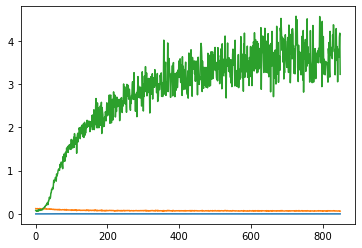

In [31]:
import matplotlib.pyplot as plt
plt.plot(np.array(x)[:, :3])

In [32]:
import visualize

In [33]:
image_A, image_B = (x[0].cuda() for x in next(zip(d1, d2)))

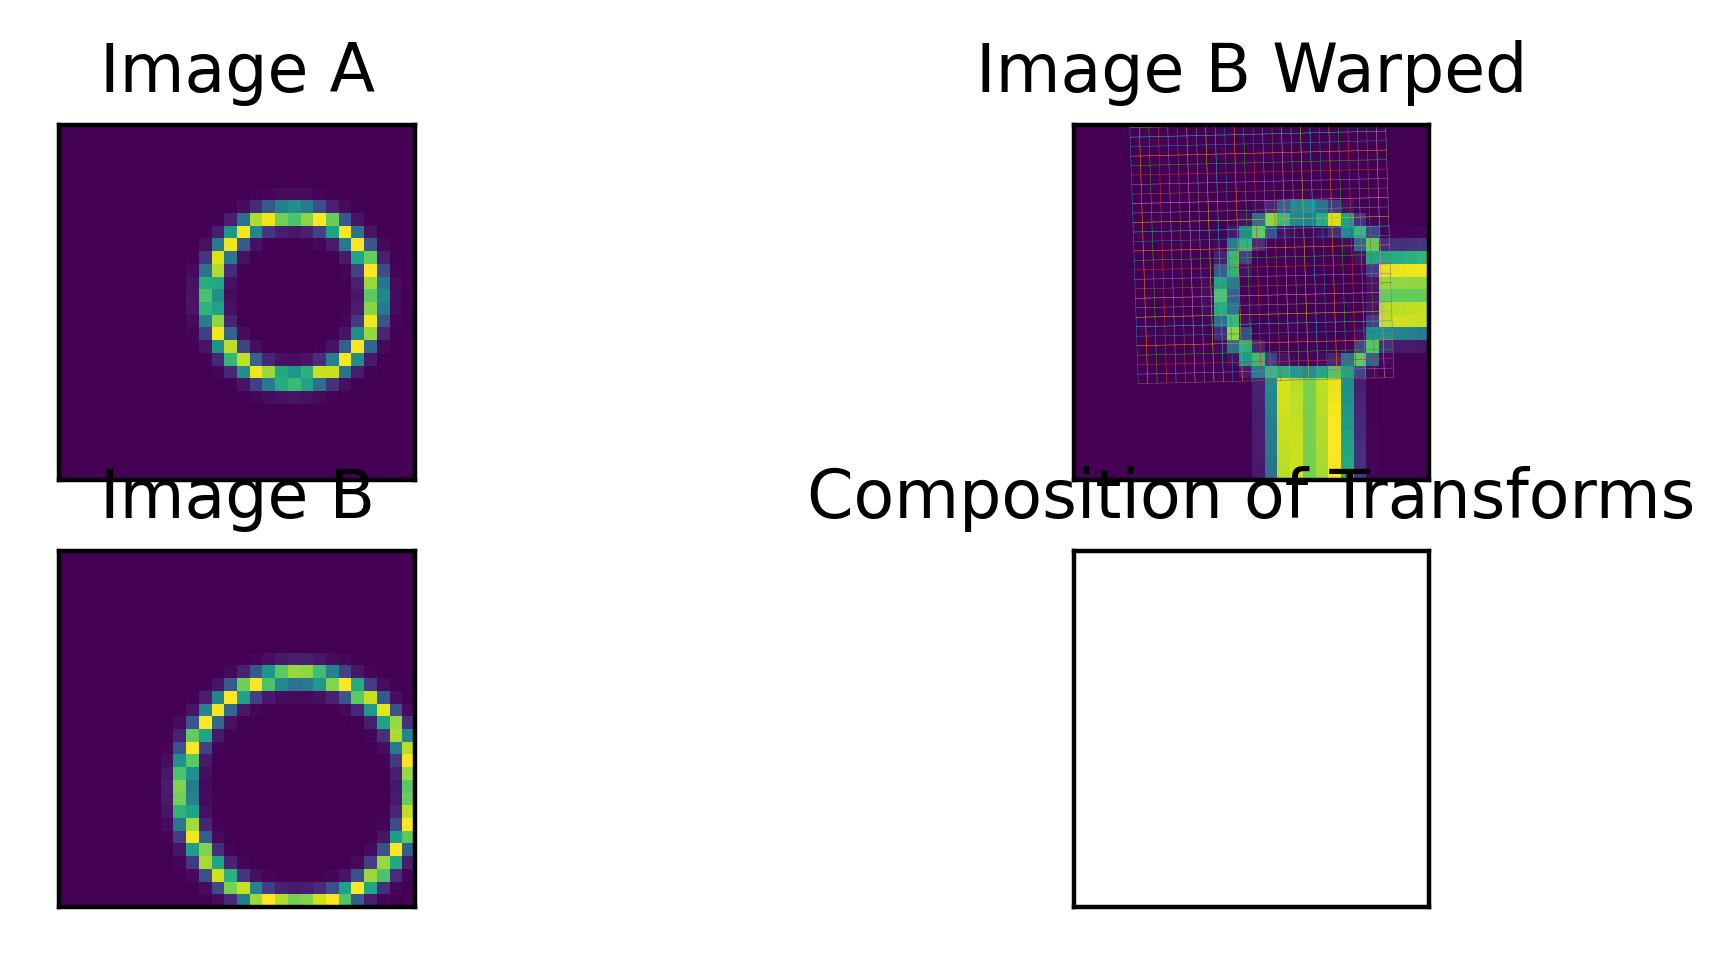

In [75]:
if not "N" in locals():
    N = 0
N += 1
try:
    visualize.visualizeRegistration(net, image_A, image_B, N, False)
except:
    pass

In [19]:
net.matrix_AB[2] @net.matrix_BA[2]

tensor([[ 1.0172e+00,  2.2982e-03, -8.4961e-03],
        [-5.0498e-04,  1.0139e+00, -6.5297e-03],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0',
       grad_fn=<MmBackward>)

In [238]:
np.matrix(net.matrix_BA[N].cpu().detach().numpy())**-1

matrix([[ 0.32406256, -0.00555886,  0.18957168],
        [ 0.01146913,  0.32829773,  0.30531105],
        [ 0.        ,  0.        ,  1.        ]], dtype=float32)

In [166]:
net.matrix_AB[0]

tensor([[1.0053, 0.0023, 0.0141],
        [0.0022, 1.0071, 0.0149],
        [0.0000, 0.0000, 1.0000]], device='cuda:0', grad_fn=<SelectBackward>)

In [121]:
batch_matrix_multiply = "ijkl,imj->imkl"

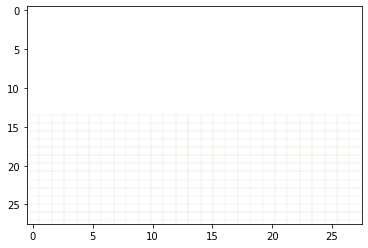

In [124]:
pp = torch.einsum(
    batch_matrix_multiply, 
    net.identityMapProjective[:1], 
    torch.Tensor([[[1, 0, .5], [0, 1, 0], [0, 0, 1]]]).cuda())[0]
visualize.show_as_grid(pp)

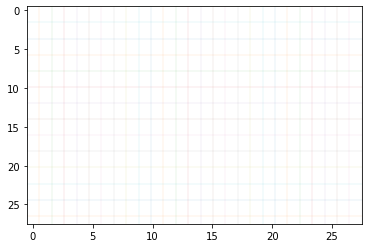

In [196]:
net.lmbda

100

In [68]:
torch.save(net.regis_net.state_dict(), "../network_weights/hollow_shape_28_affinenet.trch")